# Cogs 109: Modeling and Data Analysis
## Final project guidelines, 2019

Work in teams of at least 2 and no more than 4 students. Every student in the group will be expected to contribute substantially to the final product(s), and all students should be able to understand and explain all aspects of the project when you present your work in the final symposium.

Your project should. 
- Identify a real problem, challenge or scientific question which could benefit from data analysis and modeling. Your final report must explain why the question is interesting or important. 
- Identify a relevant data set. You should learn about how the data was collected and be able to explain key features of the data, for example: How many observations? What are the noise sources? What are the relevant predictors?
Identify at least one relevant data analysis approach, choosing from the methods covered in the course (linear or nonlinear regression, classification, clustering, PCA, etc.). Explain why this analysis approach is appropriate for addressing your question.
- Identify and explain one or more hypotheses or initial expectation that you will test using the data.
- Model selection: You should compare and contrast multiple different models (at least 2, but usually more). Your comparison should make use of cross-validation, bootstrap sampling, regularization, and/or other relevant techniques. For example, you might compare K-Nearest Neighbors classification for a range of k values (k=1,2,…,50), and select the k value that provides the lowest test set (cross-validation) error.
- Model estimation: Implement your data analysis and present the results using a combination of data visualizations (box plots, scatter plots), statistical analyses and models.
- Present your conclusions and outlook for next steps/future directions.

The final product will be a written report, 5-10 pages in length. In addition, you will create a poster explaining your project to be presented in a symposium session on the last day of class. We will provide more information about the final paper and poster in a few weeks.


## Written report:
Your final report must include the following sections (use these headings).
- Introduction. 
    - Define the real problem and explain its motivation
    - Identify the dataset you will use and explain its key characteristics.
    - Explain at least one hypothesis that you will test.
- Methods. Identify the data analysis approach you will use and explain the rationale/motivation for your choice of this approach.
- Results
    - Model selection. You MUST compare at least 2 models, using cross-validation, regularization, and/or other relevant techniques.
    - Model estimation. What are the final parameter estimates? What is the final accuracy of the model’s predictions?
    - Conclusions and discussion. What can you conclude about your hypothesis? (Note that negative or ambiguous results are perfectly acceptable, you just need to explain what you found.) What are some potential implications/next steps for researchers interested in this topic?


In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq


In [2]:
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']

In [3]:
#create kw_list 
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [4]:
df = pd.DataFrame()
print(df.empty)
pytrends = TrendReq(hl='en-US', tz=360)
for kw in kw_list:
    pytrends.build_payload([kw], cat=0, timeframe='today 3-m', geo='', gprop='')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(['isPartial'], axis=1)
    print(df_temp.columns)
    if df.empty:
        df = df_temp
    else:
        df = df.join(df_temp)

True
Index(['tesla report'], dtype='object')
Index(['tesla good'], dtype='object')
Index(['tesla bad'], dtype='object')
Index(['tesla up'], dtype='object')
Index(['tesla down'], dtype='object')
Index(['tesla stock'], dtype='object')
Index(['facebook report'], dtype='object')
Index(['facebook good'], dtype='object')
Index(['facebook bad'], dtype='object')
Index(['facebook up'], dtype='object')
Index(['facebook down'], dtype='object')
Index(['facebook stock'], dtype='object')
Index(['microsoft report'], dtype='object')
Index(['microsoft good'], dtype='object')
Index(['microsoft bad'], dtype='object')
Index(['microsoft up'], dtype='object')
Index(['microsoft down'], dtype='object')
Index(['microsoft stock'], dtype='object')
Index(['amazon report'], dtype='object')
Index(['amazon good'], dtype='object')
Index(['amazon bad'], dtype='object')
Index(['amazon up'], dtype='object')
Index(['amazon down'], dtype='object')
Index(['amazon stock'], dtype='object')
Index(['google report'], dtype='obj

In [5]:
print(df.shape)

(90, 54)


In [6]:
# get tsla stock for last 7 days
ts = 'TIME_SERIES_DAILY'
api_key = ''
outputsize = 'compact'
df_stocks = {}
for i, symbol in enumerate(company_symbol):
    link = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&outputsize={}'\
            .format(ts, symbol, api_key, outputsize)
    r = requests.get(link)
    data = json.loads(r.text)
    print(data)
    if "Time Series (Daily)" not in data:
        break
    stock_data_per_day = json.dumps(data["Time Series (Daily)"])
    df_temp = pd.read_json(stock_data_per_day).transpose()
    df_temp.reset_index(level=0, inplace=True)
    df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
    df_stocks[companies[i]] = df_temp
print(df_stocks['tesla'])

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'TSLA', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '335.2700', '2. high': '335.5000', '3. low': '327.1000', '4. close': '328.9200', '5. volume': '7937467'}, '2019-11-25': {'1. open': '344.3200', '2. high': '344.5700', '3. low': '334.4600', '4. close': '336.3400', '5. volume': '12182091'}, '2019-11-22': {'1. open': '340.1600', '2. high': '341.0000', '3. low': '330.0000', '4. close': '333.0400', '5. volume': '16870642'}, '2019-11-21': {'1. open': '354.5100', '2. high': '360.8400', '3. low': '354.0039', '4. close': '354.8300', '5. volume': '6110013'}, '2019-11-20': {'1. open': '360.0000', '2. high': '361.2000', '3. low': '349.5700', '4. close': '352.2200', '5. volume': '6733965'}, '2019-11-19': {'1. open': '351.7500', '2. high': '359.9900', '3. low': '347.8000', '4. close': '359.5200', '5. v

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'FB', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '200.0000', '2. high': '200.1500', '3. low': '198.0387', '4. close': '198.9700', '5. volume': '11727431'}, '2019-11-25': {'1. open': '199.5150', '2. high': '200.9700', '3. low': '199.2500', '4. close': '199.7900', '5. volume': '14899946'}, '2019-11-22': {'1. open': '198.3800', '2. high': '199.3000', '3. low': '197.6200', '4. close': '198.8200', '5. volume': '9959817'}, '2019-11-21': {'1. open': '197.4200', '2. high': '199.0900', '3. low': '196.8600', '4. close': '197.9300', '5. volume': '12130985'}, '2019-11-20': {'1. open': '198.5800', '2. high': '199.5900', '3. low': '195.4300', '4. close': '197.5100', '5. volume': '12370240'}, '2019-11-19': {'1. open': '197.4000', '2. high': '200.0000', '3. low': '196.8600', '4. close': '199.3200', '5. v

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'MSFT', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '151.3600', '2. high': '152.4200', '3. low': '151.3200', '4. close': '152.0300', '5. volume': '24294645'}, '2019-11-25': {'1. open': '150.0000', '2. high': '151.3500', '3. low': '149.9200', '4. close': '151.2300', '5. volume': '22153493'}, '2019-11-22': {'1. open': '150.0700', '2. high': '150.3000', '3. low': '148.8200', '4. close': '149.5900', '5. volume': '15841680'}, '2019-11-21': {'1. open': '149.4000', '2. high': '149.8000', '3. low': '148.5010', '4. close': '149.4800', '5. volume': '18576083'}, '2019-11-20': {'1. open': '150.3100', '2. high': '150.8400', '3. low': '148.4600', '4. close': '149.6200', '5. volume': '25720060'}, '2019-11-19': {'1. open': '150.8800', '2. high': '151.3300', '3. low': '150.1950', '4. close': '150.3900', '5

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AMZN', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '1779.9200', '2. high': '1797.0300', '3. low': '1778.3500', '4. close': '1796.9400', '5. volume': '3150956'}, '2019-11-25': {'1. open': '1753.2500', '2. high': '1777.4200', '3. low': '1753.2400', '4. close': '1773.8400', '5. volume': '3166566'}, '2019-11-22': {'1. open': '1739.0200', '2. high': '1746.4300', '3. low': '1731.0000', '4. close': '1745.7200', '5. volume': '2479081'}, '2019-11-21': {'1. open': '1743.0000', '2. high': '1746.8700', '3. low': '1730.3600', '4. close': '1734.7100', '5. volume': '2662938'}, '2019-11-20': {'1. open': '1749.1400', '2. high': '1762.5200', '3. low': '1734.1200', '4. close': '1745.5300', '5. volume': '2793759'}, '2019-11-19': {'1. open': '1756.9900', '2. high': '1760.6800', '3. low': '1743.0300', '4. clos

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'GOOGL', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '1309.9100', '2. high': '1314.0100', '3. low': '1304.0400', '4. close': '1313.0000', '5. volume': '1088279'}, '2019-11-25': {'1. open': '1296.2600', '2. high': '1310.4100', '3. low': '1295.6100', '4. close': '1305.6400', '5. volume': '1007664'}, '2019-11-22': {'1. open': '1303.0000', '2. high': '1306.9000', '3. low': '1289.3600', '4. close': '1293.6700', '5. volume': '1388912'}, '2019-11-21': {'1. open': '1299.2500', '2. high': '1311.1200', '3. low': '1290.7500', '4. close': '1300.1400', '5. volume': '1277338'}, '2019-11-20': {'1. open': '1311.3600', '2. high': '1313.2100', '3. low': '1289.2100', '4. close': '1301.8600', '5. volume': '1445870'}, '2019-11-19': {'1. open': '1326.6300', '2. high': '1326.6300', '3. low': '1311.7700', '4. clo

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'UBER', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '29.4900', '2. high': '30.1500', '3. low': '29.3600', '4. close': '29.5300', '5. volume': '29620840'}, '2019-11-25': {'1. open': '28.6900', '2. high': '29.6000', '3. low': '28.3800', '4. close': '29.1100', '5. volume': '36723366'}, '2019-11-22': {'1. open': '29.8400', '2. high': '30.1300', '3. low': '29.2100', '4. close': '29.5600', '5. volume': '44372625'}, '2019-11-21': {'1. open': '28.6700', '2. high': '29.6000', '3. low': '28.5000', '4. close': '29.4600', '5. volume': '54604950'}, '2019-11-20': {'1. open': '27.0600', '2. high': '28.4000', '3. low': '26.9450', '4. close': '28.0300', '5. volume': '54015857'}, '2019-11-19': {'1. open': '26.7700', '2. high': '27.2200', '3. low': '26.6100', '4. close': '27.0500', '5. volume': '34097549'}, 

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'LYFT', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '48.4900', '2. high': '49.7850', '3. low': '48.1700', '4. close': '48.9700', '5. volume': '6777554'}, '2019-11-25': {'1. open': '46.5000', '2. high': '49.3300', '3. low': '46.4700', '4. close': '48.9400', '5. volume': '9637278'}, '2019-11-22': {'1. open': '46.7000', '2. high': '47.2000', '3. low': '46.2300', '4. close': '46.4600', '5. volume': '6356480'}, '2019-11-21': {'1. open': '44.2400', '2. high': '46.8300', '3. low': '44.1000', '4. close': '46.7600', '5. volume': '10860232'}, '2019-11-20': {'1. open': '44.0000', '2. high': '44.5400', '3. low': '42.7700', '4. close': '43.9500', '5. volume': '7978126'}, '2019-11-19': {'1. open': '45.0000', '2. high': '45.0000', '3. low': '43.8100', '4. close': '44.1500', '5. volume': '3752021'}, '2019

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '266.9400', '2. high': '267.1600', '3. low': '262.5000', '4. close': '264.2900', '5. volume': '26132967'}, '2019-11-25': {'1. open': '262.7100', '2. high': '266.4400', '3. low': '262.5200', '4. close': '266.3700', '5. volume': '19242309'}, '2019-11-22': {'1. open': '262.5900', '2. high': '263.1800', '3. low': '260.8400', '4. close': '261.7800', '5. volume': '16331263'}, '2019-11-21': {'1. open': '263.6900', '2. high': '264.0050', '3. low': '261.1800', '4. close': '262.0100', '5. volume': '30348778'}, '2019-11-20': {'1. open': '265.5400', '2. high': '266.0830', '3. low': '260.4000', '4. close': '263.1900', '5. volume': '26609919'}, '2019-11-19': {'1. open': '267.9000', '2. high': '268.0000', '3. low': '265.3926', '4. close': '266.2900', '5

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'SNAP', '3. Last Refreshed': '2019-11-26', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2019-11-26': {'1. open': '15.4600', '2. high': '15.5450', '3. low': '15.1610', '4. close': '15.4600', '5. volume': '20520492'}, '2019-11-25': {'1. open': '15.5900', '2. high': '15.9000', '3. low': '15.4900', '4. close': '15.5000', '5. volume': '25203279'}, '2019-11-22': {'1. open': '15.1800', '2. high': '15.5000', '3. low': '15.0100', '4. close': '15.2600', '5. volume': '20979651'}, '2019-11-21': {'1. open': '15.3300', '2. high': '15.6300', '3. low': '15.0600', '4. close': '15.0800', '5. volume': '21544996'}, '2019-11-20': {'1. open': '15.0700', '2. high': '15.5200', '3. low': '15.0100', '4. close': '15.3100', '5. volume': '20995233'}, '2019-11-19': {'1. open': '14.5800', '2. high': '15.2600', '3. low': '14.3900', '4. close': '15.1600', '5. volume': '24822570'}, 

        times    open    high       low   close      volume
0  2019-11-26  335.27  335.50  327.1000  328.92   7937467.0
1  2019-11-25  344.32  344.57  334.4600  336.34  12182091.0
2  2019-11-22  340.16  341.00  330.0000  333.04  16870642.0
3  2019-11-21  354.51  360.84  354.0039  354.83   6110013.0
4  2019-11-20  360.00  361.20  349.5700  352.22   6733965.0
..        ...     ...     ...       ...     ...         ...
95 2019-07-15  248.00  254.42  244.8600  253.50  11000092.0
96 2019-07-12  239.75  245.38  239.7100  245.08   9200521.0
97 2019-07-11  238.14  241.50  235.8000  238.60   7514430.0
98 2019-07-10  234.15  238.94  233.1400  238.92   9145736.0
99 2019-07-09  228.97  231.00  227.2800  230.06   6190835.0

[100 rows x 6 columns]


In [7]:
df.head()

,tesla report,tesla good,tesla bad,tesla up,tesla down,tesla stock,facebook report,facebook good,facebook bad,facebook up,...,apple bad,apple up,apple down,apple stock,snap report,snap good,snap bad,snap up,snap down,snap stock
date,,,,,,,,,,,,,,,,,,,,,
2019-08-26,6,21,15,4,13,16,86,88,82,46,...,70,50,46,47,25,50,46,59,28,27
2019-08-27,8,15,13,2,13,16,79,78,92,46,...,63,49,43,41,33,45,39,55,18,24
2019-08-28,11,17,11,4,17,15,86,78,78,45,...,71,45,43,39,49,53,45,48,21,23
2019-08-29,17,15,11,2,14,14,80,82,74,44,...,58,50,38,44,24,81,39,61,27,23
2019-08-30,11,11,9,4,13,17,81,89,70,51,...,73,44,35,42,41,50,69,80,14,23


In [8]:
df_stocks['tesla'].head()
print(len(df_stocks))

9


In [9]:
#reverse df rows
df = df.iloc[::-1]
df.head()

,tesla report,tesla good,tesla bad,tesla up,tesla down,tesla stock,facebook report,facebook good,facebook bad,facebook up,...,apple bad,apple up,apple down,apple stock,snap report,snap good,snap bad,snap up,snap down,snap stock
date,,,,,,,,,,,,,,,,,,,,,
2019-11-23,45,69,100,60,91,49,61,83,63,46,...,73,54,41,18,87,53,100,55,17,7
2019-11-22,80,100,100,100,100,100,83,83,83,42,...,71,46,42,51,24,65,56,67,16,25
2019-11-21,22,21,15,14,26,28,77,91,84,44,...,72,48,46,51,48,59,38,82,27,29
2019-11-20,19,22,11,7,20,23,76,81,79,48,...,71,49,53,50,47,59,41,81,24,25
2019-11-19,21,16,22,5,23,23,86,98,81,43,...,65,54,36,54,54,93,54,58,22,30


In [10]:
tesla_names = [x for x in list(df.columns.values) if 'tesla' in x]
df_tesla_trends = df[tesla_names]

In [11]:
stock_times = df_stocks['tesla'].times
trends_times = list(df_tesla_trends.index)
joint_times = list(set(stock_times) & set(trends_times)) 

In [12]:
df_stocks['tesla'] = df_stocks['tesla'].loc[df_stocks['tesla']['times'].isin(joint_times)]
df_stocks['tesla'] = df_stocks['tesla'].reset_index()
print(df_stocks['tesla'].head())
df_tesla_trends = df_tesla_trends.loc[df_tesla_trends.index.isin(joint_times)]
df_tesla_trends = df_tesla_trends.reset_index()
df_tesla_trends.columns = ['_'.join(x.split()) for x in list(df_tesla_trends.columns) if len(x) > 1]
print(df_tesla_trends.head())

   index      times      open    high       low   close      volume
0      2 2019-11-22  340.1600  341.00  330.0000  333.04  16870642.0
1      3 2019-11-21  354.5100  360.84  354.0039  354.83   6110013.0
2      4 2019-11-20  360.0000  361.20  349.5700  352.22   6733965.0
3      5 2019-11-19  351.7500  359.99  347.8000  359.52   7736078.0
4      6 2019-11-18  352.9165  353.15  346.1000  349.99   4408505.0
        date  tesla_report  tesla_good  tesla_bad  tesla_up  tesla_down  \
0 2019-11-22            80         100        100       100         100   
1 2019-11-21            22          21         15        14          26   
2 2019-11-20            19          22         11         7          20   
3 2019-11-19            21          16         22         5          23   
4 2019-11-18            13          24         16         4          15   

   tesla_stock  
0          100  
1           28  
2           23  
3           23  
4           20  


In [13]:
df_tesla = df_tesla_trends.join(df_stocks['tesla'])

In [14]:
df_tesla['profit'] = df_tesla['open']-df_tesla['close']
df_tesla = df_tesla.iloc[::-1]
df_tesla.head()

,date,tesla_report,tesla_good,tesla_bad,tesla_up,tesla_down,tesla_stock,index,times,open,high,low,close,volume,profit
63,2019-08-26,6,21,15,4,13,16,65,2019-08-26,213.60,215.02,211.540,215.00,5054414.0,-1.40
62,2019-08-27,8,15,13,2,13,16,64,2019-08-27,215.74,218.80,212.030,214.08,5420727.0,1.66
61,2019-08-28,11,17,11,4,17,15,63,2019-08-28,213.69,217.25,212.310,215.59,3223082.0,-1.90
60,2019-08-29,17,15,11,2,14,14,62,2019-08-29,219.00,223.40,218.000,221.71,5183104.0,-2.71
59,2019-08-30,11,11,9,4,13,17,61,2019-08-30,229.15,232.44,224.213,225.61,9327775.0,3.54


In [15]:
# Split into training and testing data
df_tesla_train = df_tesla[:50]
print(df_tesla_train.shape)
df_tesla_test = df_tesla[50:]
print(df_tesla_test.shape)

(50, 15)
(14, 15)


In [16]:
mdl=sm.formula.ols(formula='profit ~ 1 + tesla_report + tesla_good + tesla_bad + tesla_up + tesla_down', data=df_tesla_train).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.075
Method:                 Least Squares   F-statistic:                    0.3190
Date:                Tue, 26 Nov 2019   Prob (F-statistic):              0.899
Time:                        14:15:08   Log-Likelihood:                -161.26
No. Observations:                  50   AIC:                             334.5
Df Residuals:                      44   BIC:                             346.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.2670      6.618     -0.191      0.849     -14.605      12.071
tesla_report     0.0228      0.070      0.327      0.745      -0.118       0.164
tesla_good      -0.0997      0.223     -0.448      0.656      -0.548       0.349
tesla_bad        0.0896      0.212      0.422      0.675      -0.338       0.517
tesla_up        -0.6490      1.172     -0.554      0.583      -3.011       1.713
tesla_down       0.1060      0.117      0.910      0.368      -0.129       0.341
==============================================================================
Omnibus:                       35.099   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.034
Skew:                          -1.619   Prob(JB):                     7.95e-35
Kurtosis:                      11.055   Cond. No.                         280.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
mdl=sm.formula.ols(formula='close ~ 1 + tesla_report + tesla_good + tesla_bad + tesla_up + tesla_down', data=df_tesla_train).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     4.372
Date:                Tue, 26 Nov 2019   Prob (F-statistic):            0.00257
Time:                        14:15:09   Log-Likelihood:                -232.05
No. Observations:                  50   AIC:                             476.1
Df Residuals:                      44   BIC:                             487.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      164.2554     27.263      6.025      0.000     109.311     219.200
tesla_report     0.1774      0.288      0.616      0.541      -0.403       0.758
tesla_good       0.2602      0.917      0.284      0.778      -1.588       2.108
tesla_bad        2.3155      0.875      2.647      0.011       0.553       4.078
tesla_up        17.5549      4.828      3.636      0.001       7.825      27.285
tesla_down      -0.8864      0.480     -1.846      0.072      -1.854       0.081
==============================================================================
Omnibus:                       10.201   Durbin-Watson:                   0.817
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.710
Skew:                           0.962   Prob(JB):                      0.00779
Kurtosis:                       3.981   Cond. No.                         280.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
cols = ['tesla_report', 'tesla_good', 'tesla_bad', 'tesla_up', 'tesla_down']

In [19]:
#ridge regression
X = df_tesla_train[cols]
y = df_tesla_train['profit']
alpha = []
MSE_train = []
MSE_test = []
for i in range(90, 1000, 10):
    clf = Ridge(alpha=i)
    clf.fit(X, y) 
    print("alpha: "+str(i))
    print("Training error = "+str(mean_squared_error(clf.predict(df_tesla_train[cols]), df_tesla_train['profit'])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_tesla_test[cols]), df_tesla_test['profit'])))
    print()
    alpha.append(i)
    MSE_train.append(mean_squared_error(clf.predict(df_tesla_train[cols]), df_tesla_train['profit']))
    MSE_test.append(mean_squared_error(clf.predict(df_tesla_test[cols]), df_tesla_test['profit']))

alpha: 90
Training error = 37.20345248246926
Testing error = 43.63594285174065

alpha: 100
Training error = 37.21170608271836
Testing error = 41.01697059212729

alpha: 110
Training error = 37.219094762531796
Testing error = 38.93828900917229

alpha: 120
Training error = 37.22577023175212
Testing error = 37.260770197625696

alpha: 130
Training error = 37.23185260630567
Testing error = 35.887304161472045

alpha: 140
Training error = 37.237437842553646
Testing error = 34.74845235852827

alpha: 150
Training error = 37.24260328246886
Testing error = 33.79350486773027

alpha: 160
Training error = 37.24741180087624
Testing error = 32.98473492787965

alpha: 170
Training error = 37.251914926867116
Testing error = 32.293608437408146

alpha: 180
Training error = 37.25615521203198
Testing error = 31.69822377507504

alpha: 190
Training error = 37.2601680429586
Testing error = 31.181545992839947

alpha: 200
Training error = 37.263983040754425
Testing error = 30.730165783341644

alpha: 210
Training e

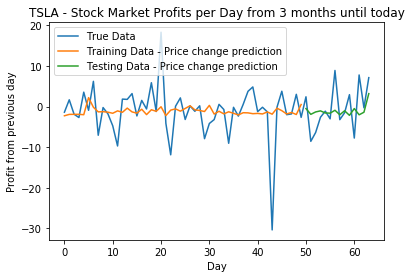

In [20]:
#plot data with training and test data
clf = Ridge(alpha=510)
clf.fit(X, y) 
plt.plot(range(64) , df_tesla["profit"], range(50), clf.predict(df_tesla_train[cols]), '-', range(50, 64), clf.predict(df_tesla_test[cols]), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('TSLA - Stock Market Profits per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [21]:
#ridge regression
X = df_tesla_train[cols]
y = df_tesla_train['close']
clf = Ridge(alpha=510.0)
clf.fit(X, y) 
print("Training error = "+str(mean_squared_error(clf.predict(df_tesla_train[cols]), df_tesla_train['close'])))
print("Testing error = "+str(mean_squared_error(clf.predict(df_tesla_test[cols]), df_tesla_test['close'])))

Training error = 807.8682871119614
Testing error = 8432.633088648823


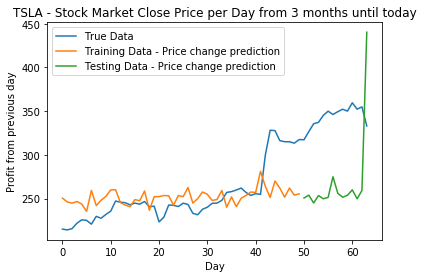

In [22]:
#plot data with training and test data
clf = Ridge(alpha=510)
clf.fit(X, y) 
plt.plot(range(64) , df_tesla["close"], range(50), clf.predict(df_tesla_train[cols]), '-', range(50, 64), clf.predict(df_tesla_test[cols]), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('TSLA - Stock Market Close Price per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [23]:
df_stocks['facebook'].head()

,times,open,high,low,close,volume
0,2019-11-26,200.000,200.15,198.0387,198.97,11727431.0
1,2019-11-25,199.515,200.97,199.2500,199.79,14899946.0
2,2019-11-22,198.380,199.30,197.6200,198.82,9959817.0
3,2019-11-21,197.420,199.09,196.8600,197.93,12130985.0
4,2019-11-20,198.580,199.59,195.4300,197.51,12370240.0


In [24]:
fb_names = [x for x in list(df.columns.values) if 'facebook' in x]
df_fb_trends = df[fb_names]
stock_times = df_stocks['facebook'].times
trends_times = list(df_fb_trends.index)
joint_times = list(set(stock_times) & set(trends_times)) 
df_stocks['facebook'] = df_stocks['facebook'].loc[df_stocks['facebook']['times'].isin(joint_times)]
df_stocks['facebook'] = df_stocks['facebook'].reset_index()
print(df_stocks['facebook'].head())
df_fb_trends = df_fb_trends.loc[df_fb_trends.index.isin(joint_times)]
df_fb_trends = df_fb_trends.reset_index()
df_fb_trends.columns = ['_'.join(x.split()) for x in list(df_fb_trends.columns) if len(x) > 1]
print(df_fb_trends.head())
df_fb = df_fb_trends.join(df_stocks['facebook'])
df_fb['profit'] = df_fb['open']-df_fb['close']
df_fb = df_fb.iloc[::-1]
df_fb.head()

   index      times    open    high     low   close      volume
0      2 2019-11-22  198.38  199.30  197.62  198.82   9959817.0
1      3 2019-11-21  197.42  199.09  196.86  197.93  12130985.0
2      4 2019-11-20  198.58  199.59  195.43  197.51  12370240.0
3      5 2019-11-19  197.40  200.00  196.86  199.32  19070291.0
4      6 2019-11-18  194.56  198.63  193.05  197.40  16176107.0
        date  facebook_report  facebook_good  facebook_bad  facebook_up  \
0 2019-11-22               83             83            83           42   
1 2019-11-21               77             91            84           44   
2 2019-11-20               76             81            79           48   
3 2019-11-19               86             98            81           43   
4 2019-11-18               72            100            73           42   

   facebook_down  facebook_stock  
0             42              62  
1             48              68  
2             46              64  
3             57         

,date,facebook_report,facebook_good,facebook_bad,facebook_up,facebook_down,facebook_stock,index,times,open,high,low,close,volume,profit
63,2019-08-26,86,88,82,46,58,65,65,2019-08-26,179.40,180.5000,178.2400,180.36,8780477.0,-0.96
62,2019-08-27,79,78,92,46,63,71,64,2019-08-27,181.93,184.0400,181.0100,181.30,14408946.0,0.63
61,2019-08-28,86,78,78,45,56,65,63,2019-08-28,180.53,181.9500,178.9200,181.76,9364533.0,-1.23
60,2019-08-29,80,82,74,44,53,68,62,2019-08-29,183.77,186.0752,183.4700,185.57,10135033.0,-1.80
59,2019-08-30,81,89,70,51,57,55,61,2019-08-30,186.78,186.8017,183.4585,185.67,10785722.0,1.11


In [25]:
cols = ['facebook_'+ x for x in key_terms]
print(cols)

['facebook_report', 'facebook_good', 'facebook_bad', 'facebook_up', 'facebook_down', 'facebook_stock']


In [26]:
# Split into training and testing data
df_fb_train = df_fb[:50]
print(df_fb_train.shape)
df_fb_test = df_fb[50:]
print(df_fb_test.shape)

(50, 15)
(14, 15)


In [27]:
#ridge regression
X = df_fb_train[cols]
y = df_fb_train['profit']
alpha = []
MSE_train = []
MSE_test = []
for i in range(90, 1000, 10):
    clf = Ridge(alpha=i)
    clf.fit(X, y) 
    print("alpha: "+str(i))
    print("Training error = "+str(mean_squared_error(clf.predict(df_fb_train[cols]), df_fb_train['profit'])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_fb_test[cols]), df_fb_test['profit'])))
    print()
    alpha.append(i)
    MSE_train.append(mean_squared_error(clf.predict(df_fb_train[cols]), df_fb_train['profit']))
    MSE_test.append(mean_squared_error(clf.predict(df_fb_test[cols]), df_fb_test['profit']))

alpha: 90
Training error = 5.737559832592206
Testing error = 7.719898746451869

alpha: 100
Training error = 5.737760476487373
Testing error = 7.691193391285803

alpha: 110
Training error = 5.737978048176092
Testing error = 7.66288201038614

alpha: 120
Training error = 5.738211877898701
Testing error = 7.634956165258961

alpha: 130
Training error = 5.738461324413097
Testing error = 7.607407668389855

alpha: 140
Training error = 5.738725773560966
Testing error = 7.58022857356625

alpha: 150
Training error = 5.739004636918083
Testing error = 7.553411166660942

alpha: 160
Training error = 5.739297350523055
Testing error = 7.526947956850663

alpha: 170
Training error = 5.739603373679244
Testing error = 7.500831668245128

alpha: 180
Training error = 5.739922187825141
Testing error = 7.47505523190378

alpha: 190
Training error = 5.740253295468688
Testing error = 7.449611778218722

alpha: 200
Training error = 5.740596219181395
Testing error = 7.424494629643915

alpha: 210
Training error = 5.74

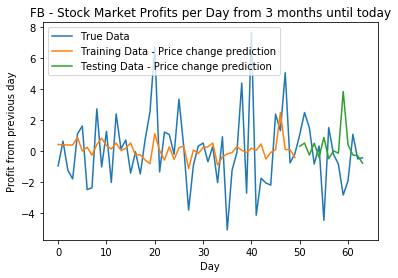

In [28]:
#plot data with training and test data
X = df_fb_train[cols]
y = df_fb_train['profit']
clf = Ridge(alpha=510)
clf.fit(X, y) 
plt.plot(range(64) , df_fb["profit"], range(50), clf.predict(df_fb_train[cols]), '-', range(50, 64), clf.predict(df_fb_test[cols]), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('FB - Stock Market Profits per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

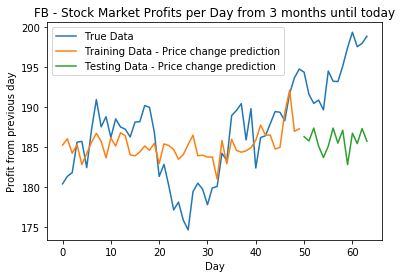

In [29]:
X = df_fb_train[cols]
y = df_fb_train['close']
clf = Ridge(alpha=510)
clf.fit(X, y) 
plt.plot(range(64) , df_fb["close"], range(50), clf.predict(df_fb_train[cols]), '-', range(50, 64), clf.predict(df_fb_test[cols]), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('FB - Stock Market Profits per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [35]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [36]:
cols = ['facebook_'+ x for x in key_terms]
df_fb['mid'] = (df_fb['high'] + df_fb['low'])/2
df_fb[cols+['mid']]

,facebook_report,facebook_good,facebook_bad,facebook_up,facebook_down,facebook_stock,mid
63,86,88,82,46,58,65,179.3700
62,79,78,92,46,63,71,182.5250
61,86,78,78,45,56,65,180.4350
60,80,82,74,44,53,68,184.7726
59,81,89,70,51,57,55,185.1301
...,...,...,...,...,...,...,...
4,72,100,73,42,100,63,195.8400
3,86,98,81,43,57,68,198.4300
2,76,81,79,48,46,64,197.5100
1,77,91,84,44,48,68,197.9750


In [50]:
#scale data to be between 0-1 
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_fb[cols+['mid']])
print(data_set_scaled)

[[0.6        0.52       0.70588235 0.06896552 0.36363636 0.32692308
  0.19281184]
 [0.4        0.12       1.         0.06896552 0.43939394 0.44230769
  0.32621564]
 [0.6        0.12       0.58823529 0.05172414 0.33333333 0.32692308
  0.23784355]
 [0.42857143 0.28       0.47058824 0.03448276 0.28787879 0.38461538
  0.42125159]
 [0.45714286 0.56       0.35294118 0.15517241 0.34848485 0.13461538
  0.43636786]
 [0.65714286 0.52       0.52941176 0.05172414 0.22727273 0.19230769
  0.38393235]
 [0.14285714 0.48       0.5        0.10344828 0.24242424 0.30769231
  0.46552643]
 [0.31428571 0.44       1.         0.06896552 0.28787879 0.34615385
  0.62748414]
 [0.28571429 0.8        0.41176471 0.06896552 0.25757576 0.28846154
  0.56955603]
 [0.42857143 0.44       0.58823529 0.10344828 0.40909091 0.21153846
  0.53290909]
 [0.14285714 0.6        0.64705882 0.10344828 0.3030303  0.32692308
  0.48689218]
 [1.         0.4        0.47058824 0.03448276 0.25757576 0.40384615
  0.54756871]
 [0.42857143 0.9

In [51]:
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50, 1, 6) (50,) (14, 1, 6) (14,)


In [52]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [53]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 50 samples, validate on 14 samples
Epoch 1/500
 - 1s - loss: 0.4249 - val_loss: 0.8111
Epoch 2/500
 - 0s - loss: 0.4163 - val_loss: 0.8021
Epoch 3/500
 - 0s - loss: 0.4078 - val_loss: 0.7931
Epoch 4/500
 - 0s - loss: 0.3992 - val_loss: 0.7840
Epoch 5/500
 - 0s - loss: 0.3906 - val_loss: 0.7750
Epoch 6/500
 - 0s - loss: 0.3820 - val_loss: 0.7659
Epoch 7/500
 - 0s - loss: 0.3734 - val_loss: 0.7568
Epoch 8/500
 - 0s - loss: 0.3647 - val_loss: 0.7477
Epoch 9/500
 - 0s - loss: 0.3564 - val_loss: 0.7385
Epoch 10/500
 - 0s - loss: 0.3480 - val_loss: 0.7294
Epoch 11/500
 - 0s - loss: 0.3397 - val_loss: 0.7201
Epoch 12/500
 - 0s - loss: 0.3312 - val_loss: 0.7109
Epoch 13/500
 - 0s - loss: 0.3231 - val_loss: 0.7016
Epoch 14/500
 - 0s - loss: 0.3151 - val_loss: 0.6923
Epoch 15/500
 - 0s - loss: 0.3078 - val_loss: 0.6830
Epoch 16/500
 - 0s - loss: 0.3004 - val_loss: 0.6737
Epoch 17/500
 - 0s - loss: 0.2931 - val_loss: 0.6644
Epoch 18/500
 - 0s - loss: 0.2857 - val_loss: 0.6550
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.1416 - val_loss: 0.3480
Epoch 155/500
 - 0s - loss: 0.1416 - val_loss: 0.3479
Epoch 156/500
 - 0s - loss: 0.1416 - val_loss: 0.3478
Epoch 157/500
 - 0s - loss: 0.1415 - val_loss: 0.3479
Epoch 158/500
 - 0s - loss: 0.1415 - val_loss: 0.3480
Epoch 159/500
 - 0s - loss: 0.1414 - val_loss: 0.3482
Epoch 160/500
 - 0s - loss: 0.1414 - val_loss: 0.3481
Epoch 161/500
 - 0s - loss: 0.1414 - val_loss: 0.3479
Epoch 162/500
 - 0s - loss: 0.1413 - val_loss: 0.3477
Epoch 163/500
 - 0s - loss: 0.1413 - val_loss: 0.3475
Epoch 164/500
 - 0s - loss: 0.1413 - val_loss: 0.3474
Epoch 165/500
 - 0s - loss: 0.1412 - val_loss: 0.3473
Epoch 166/500
 - 0s - loss: 0.1412 - val_loss: 0.3474
Epoch 167/500
 - 0s - loss: 0.1412 - val_loss: 0.3475
Epoch 168/500
 - 0s - loss: 0.1411 - val_loss: 0.3476
Epoch 169/500
 - 0s - loss: 0.1411 - val_loss: 0.3475
Epoch 170/500
 - 0s - loss: 0.1410 - val_loss: 0.3473
Epoch 171/500
 - 0s - loss: 0.1410 - val_loss: 0.3471
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.1376 - val_loss: 0.3418
Epoch 307/500
 - 0s - loss: 0.1376 - val_loss: 0.3419
Epoch 308/500
 - 0s - loss: 0.1375 - val_loss: 0.3422
Epoch 309/500
 - 0s - loss: 0.1375 - val_loss: 0.3422
Epoch 310/500
 - 0s - loss: 0.1375 - val_loss: 0.3419
Epoch 311/500
 - 0s - loss: 0.1375 - val_loss: 0.3423
Epoch 312/500
 - 0s - loss: 0.1375 - val_loss: 0.3427
Epoch 313/500
 - 0s - loss: 0.1375 - val_loss: 0.3430
Epoch 314/500
 - 0s - loss: 0.1375 - val_loss: 0.3430
Epoch 315/500
 - 0s - loss: 0.1374 - val_loss: 0.3427
Epoch 316/500
 - 0s - loss: 0.1374 - val_loss: 0.3423
Epoch 317/500
 - 0s - loss: 0.1374 - val_loss: 0.3422
Epoch 318/500
 - 0s - loss: 0.1374 - val_loss: 0.3427
Epoch 319/500
 - 0s - loss: 0.1374 - val_loss: 0.3432
Epoch 320/500
 - 0s - loss: 0.1374 - val_loss: 0.3430
Epoch 321/500
 - 0s - loss: 0.1373 - val_loss: 0.3427
Epoch 322/500
 - 0s - loss: 0.1373 - val_loss: 0.3428
Epoch 323/500
 - 0s - loss: 0.1373 - val_loss: 0.3431
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.1354 - val_loss: 0.3450
Epoch 459/500
 - 0s - loss: 0.1354 - val_loss: 0.3456
Epoch 460/500
 - 0s - loss: 0.1354 - val_loss: 0.3454
Epoch 461/500
 - 0s - loss: 0.1354 - val_loss: 0.3446
Epoch 462/500
 - 0s - loss: 0.1354 - val_loss: 0.3446
Epoch 463/500
 - 0s - loss: 0.1354 - val_loss: 0.3454
Epoch 464/500
 - 0s - loss: 0.1354 - val_loss: 0.3453
Epoch 465/500
 - 0s - loss: 0.1353 - val_loss: 0.3444
Epoch 466/500
 - 0s - loss: 0.1353 - val_loss: 0.3443
Epoch 467/500
 - 0s - loss: 0.1353 - val_loss: 0.3446
Epoch 468/500
 - 0s - loss: 0.1353 - val_loss: 0.3450
Epoch 469/500
 - 0s - loss: 0.1353 - val_loss: 0.3450
Epoch 470/500
 - 0s - loss: 0.1352 - val_loss: 0.3444
Epoch 471/500
 - 0s - loss: 0.1352 - val_loss: 0.3442
Epoch 472/500
 - 0s - loss: 0.1352 - val_loss: 0.3444
Epoch 473/500
 - 0s - loss: 0.1352 - val_loss: 0.3449
Epoch 474/500
 - 0s - loss: 0.1351 - val_loss: 0.3449
Epoch 475/500
 - 0s - loss: 0.1351 - val_loss: 0.3441
Epoch 476/500
 - 0s - loss: 

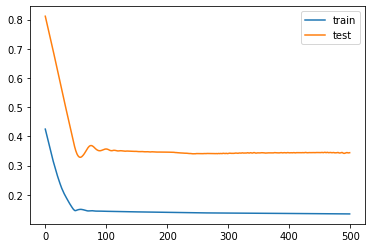

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

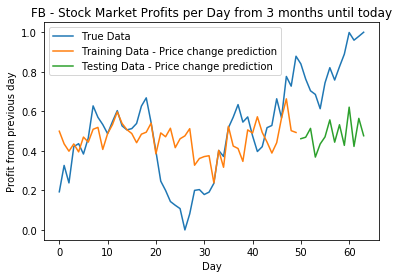

In [60]:
plt.plot(range(64) , list(np.array(train_y))+list(np.array(test_y)), range(50), model.predict(train_X), '-', range(50, 64), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('FB Keras - Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [57]:
df_stocks['microsoft']

,times,open,high,low,close,volume
0,2019-11-26,151.36,152.42,151.3200,152.03,24294645.0
1,2019-11-25,150.00,151.35,149.9200,151.23,22153493.0
2,2019-11-22,150.07,150.30,148.8200,149.59,15841680.0
3,2019-11-21,149.40,149.80,148.5010,149.48,18576083.0
4,2019-11-20,150.31,150.84,148.4600,149.62,25720060.0
...,...,...,...,...,...,...
95,2019-07-15,139.44,139.54,138.4600,138.90,16651457.0
96,2019-07-12,138.85,139.13,138.0099,138.90,18936832.0
97,2019-07-11,138.20,139.22,137.8700,138.40,22327942.0
98,2019-07-10,137.13,138.58,137.0200,137.85,24204362.0


In [70]:
df_msft = df_stocks['microsoft'][['high', 'low']].iloc[::-1]
df_msft['mid'] = (df_msft['high'] + df_msft['low']) /2

In [71]:
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_msft[['high', 'low', 'mid']])

In [72]:
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50, 1, 2) (50,) (50, 1, 2) (50,)


In [73]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [74]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 50 samples, validate on 50 samples
Epoch 1/500
 - 1s - loss: 0.2750 - val_loss: 0.5443
Epoch 2/500
 - 0s - loss: 0.2704 - val_loss: 0.5381
Epoch 3/500
 - 0s - loss: 0.2659 - val_loss: 0.5319
Epoch 4/500
 - 0s - loss: 0.2614 - val_loss: 0.5258
Epoch 5/500
 - 0s - loss: 0.2569 - val_loss: 0.5196
Epoch 6/500
 - 0s - loss: 0.2524 - val_loss: 0.5134
Epoch 7/500
 - 0s - loss: 0.2478 - val_loss: 0.5072
Epoch 8/500
 - 0s - loss: 0.2433 - val_loss: 0.5010
Epoch 9/500
 - 0s - loss: 0.2388 - val_loss: 0.4948
Epoch 10/500
 - 0s - loss: 0.2343 - val_loss: 0.4886
Epoch 11/500
 - 0s - loss: 0.2297 - val_loss: 0.4824
Epoch 12/500
 - 0s - loss: 0.2251 - val_loss: 0.4761
Epoch 13/500
 - 0s - loss: 0.2206 - val_loss: 0.4699
Epoch 14/500
 - 0s - loss: 0.2160 - val_loss: 0.4636
Epoch 15/500
 - 0s - loss: 0.2114 - val_loss: 0.4573
Epoch 16/500
 - 0s - loss: 0.2067 - val_loss: 0.4509
Epoch 17/500
 - 0s - loss: 0.2021 - val_loss: 0.4445
Epoch 18/500
 - 0s - loss: 0.1974 - val_loss: 0.4381
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.0331 - val_loss: 0.0954
Epoch 155/500
 - 0s - loss: 0.0328 - val_loss: 0.0944
Epoch 156/500
 - 0s - loss: 0.0325 - val_loss: 0.0933
Epoch 157/500
 - 0s - loss: 0.0322 - val_loss: 0.0922
Epoch 158/500
 - 0s - loss: 0.0319 - val_loss: 0.0911
Epoch 159/500
 - 0s - loss: 0.0317 - val_loss: 0.0899
Epoch 160/500
 - 0s - loss: 0.0314 - val_loss: 0.0887
Epoch 161/500
 - 0s - loss: 0.0311 - val_loss: 0.0875
Epoch 162/500
 - 0s - loss: 0.0308 - val_loss: 0.0864
Epoch 163/500
 - 0s - loss: 0.0305 - val_loss: 0.0852
Epoch 164/500
 - 0s - loss: 0.0302 - val_loss: 0.0840
Epoch 165/500
 - 0s - loss: 0.0299 - val_loss: 0.0828
Epoch 166/500
 - 0s - loss: 0.0296 - val_loss: 0.0815
Epoch 167/500
 - 0s - loss: 0.0292 - val_loss: 0.0803
Epoch 168/500
 - 0s - loss: 0.0289 - val_loss: 0.0791
Epoch 169/500
 - 0s - loss: 0.0286 - val_loss: 0.0777
Epoch 170/500
 - 0s - loss: 0.0283 - val_loss: 0.0764
Epoch 171/500
 - 0s - loss: 0.0280 - val_loss: 0.0750
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0022 - val_loss: 0.0297
Epoch 307/500
 - 0s - loss: 0.0022 - val_loss: 0.0301
Epoch 308/500
 - 0s - loss: 0.0022 - val_loss: 0.0301
Epoch 309/500
 - 0s - loss: 0.0022 - val_loss: 0.0299
Epoch 310/500
 - 0s - loss: 0.0022 - val_loss: 0.0295
Epoch 311/500
 - 0s - loss: 0.0022 - val_loss: 0.0296
Epoch 312/500
 - 0s - loss: 0.0022 - val_loss: 0.0295
Epoch 313/500
 - 0s - loss: 0.0022 - val_loss: 0.0291
Epoch 314/500
 - 0s - loss: 0.0022 - val_loss: 0.0295
Epoch 315/500
 - 0s - loss: 0.0022 - val_loss: 0.0295
Epoch 316/500
 - 0s - loss: 0.0022 - val_loss: 0.0293
Epoch 317/500
 - 0s - loss: 0.0022 - val_loss: 0.0289
Epoch 318/500
 - 0s - loss: 0.0022 - val_loss: 0.0289
Epoch 319/500
 - 0s - loss: 0.0022 - val_loss: 0.0290
Epoch 320/500
 - 0s - loss: 0.0022 - val_loss: 0.0289
Epoch 321/500
 - 0s - loss: 0.0022 - val_loss: 0.0285
Epoch 322/500
 - 0s - loss: 0.0022 - val_loss: 0.0288
Epoch 323/500
 - 0s - loss: 0.0021 - val_loss: 0.0289
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0018 - val_loss: 0.0181
Epoch 459/500
 - 0s - loss: 0.0015 - val_loss: 0.0191
Epoch 460/500
 - 0s - loss: 0.0020 - val_loss: 0.0165
Epoch 461/500
 - 0s - loss: 0.0019 - val_loss: 0.0161
Epoch 462/500
 - 0s - loss: 0.0022 - val_loss: 0.0170
Epoch 463/500
 - 0s - loss: 0.0015 - val_loss: 0.0194
Epoch 464/500
 - 0s - loss: 0.0024 - val_loss: 0.0177
Epoch 465/500
 - 0s - loss: 0.0015 - val_loss: 0.0163
Epoch 466/500
 - 0s - loss: 0.0018 - val_loss: 0.0163
Epoch 467/500
 - 0s - loss: 0.0017 - val_loss: 0.0179
Epoch 468/500
 - 0s - loss: 0.0015 - val_loss: 0.0177
Epoch 469/500
 - 0s - loss: 0.0015 - val_loss: 0.0167
Epoch 470/500
 - 0s - loss: 0.0014 - val_loss: 0.0165
Epoch 471/500
 - 0s - loss: 0.0015 - val_loss: 0.0172
Epoch 472/500
 - 0s - loss: 0.0014 - val_loss: 0.0175
Epoch 473/500
 - 0s - loss: 0.0015 - val_loss: 0.0158
Epoch 474/500
 - 0s - loss: 0.0016 - val_loss: 0.0158
Epoch 475/500
 - 0s - loss: 0.0016 - val_loss: 0.0172
Epoch 476/500
 - 0s - loss: 

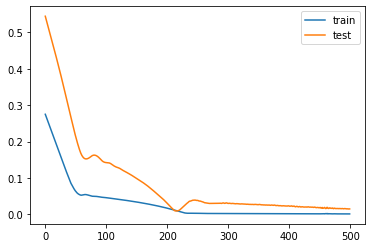

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

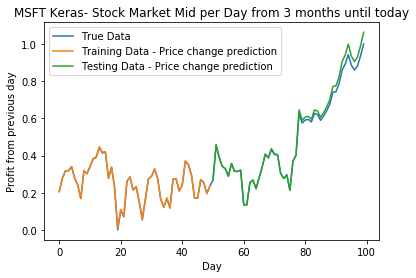

In [77]:
plt.plot(range(100) , list(np.array(train_y))+list(np.array(test_y)), range(50), model.predict(train_X), '-', range(50, 100), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('MSFT Keras- Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()